In [ ]:
import json
import time
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import os
import itertools
import csv
from itertools import islice

## Dataset Generator

The dataset is generated and saved in `angry_birds_levels.json` file and can be reused. This saves a good amount of time in generating dataset again.

✅ Dataset generated & saved → angry_birds_levels.json


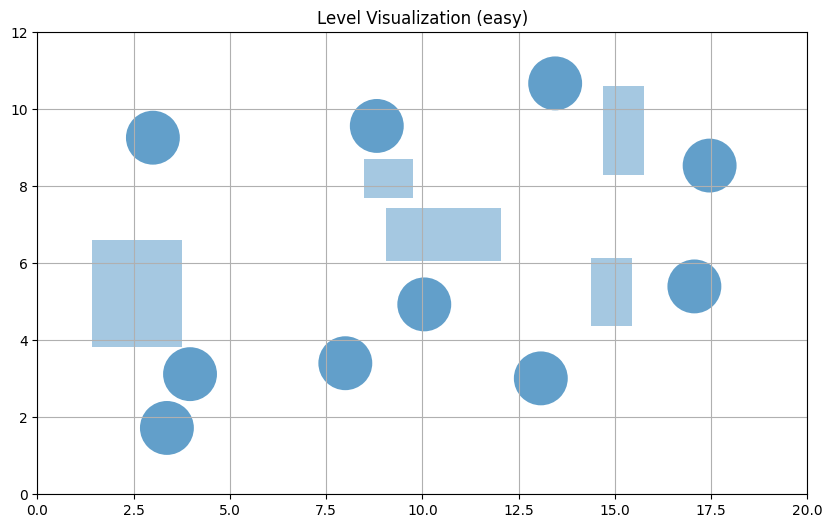

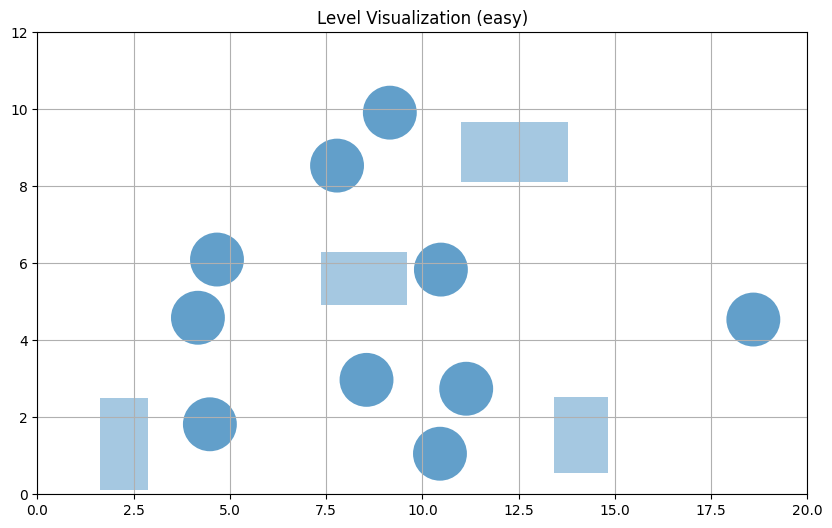

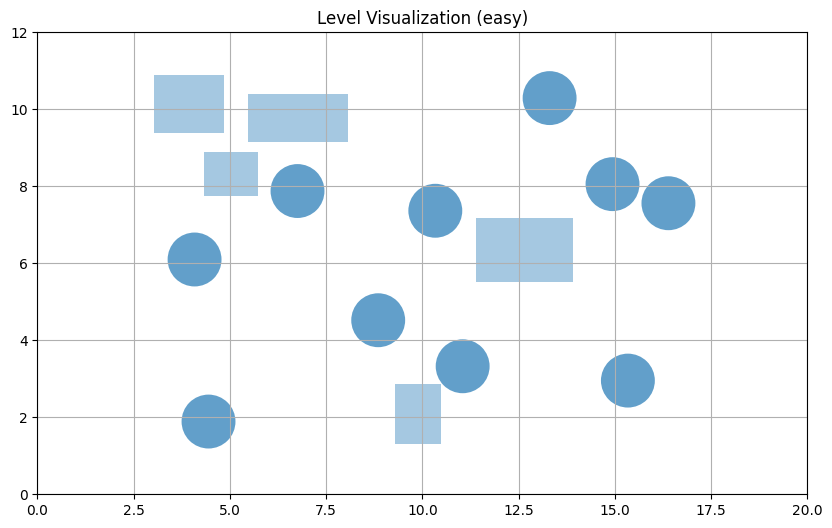

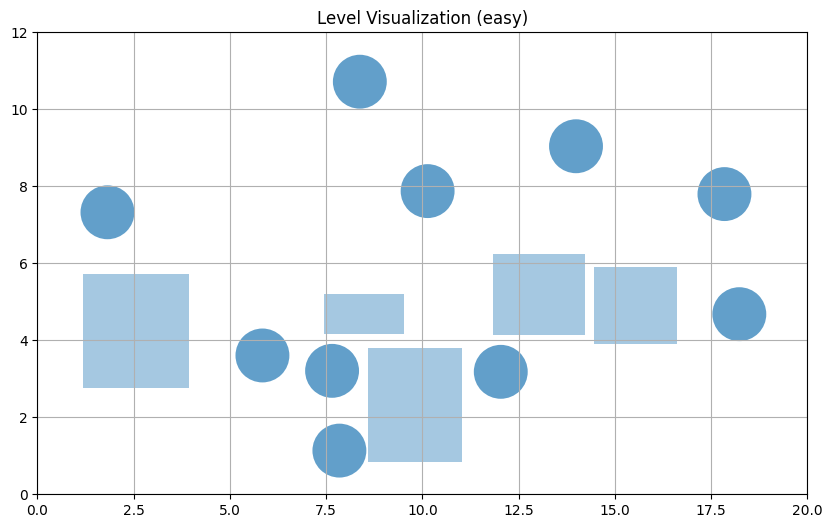

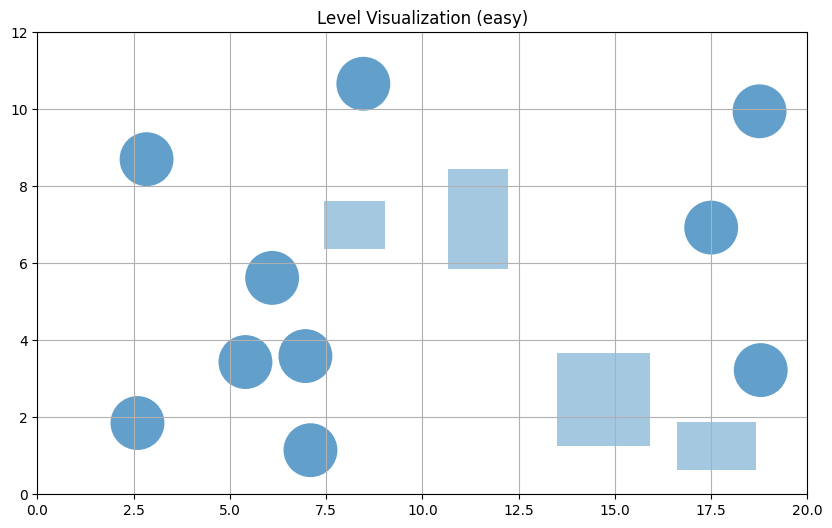

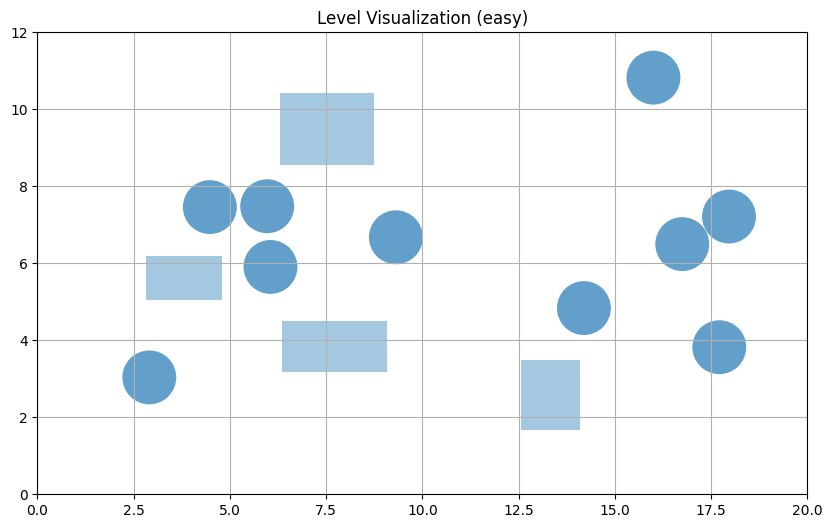

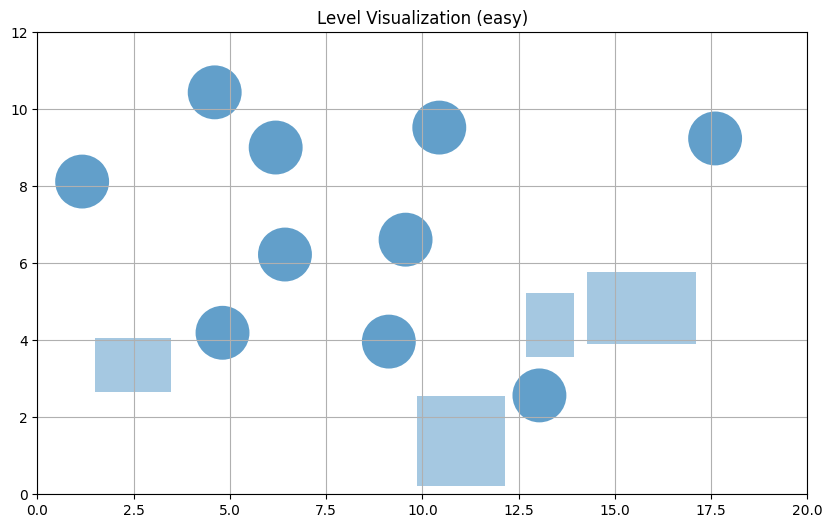

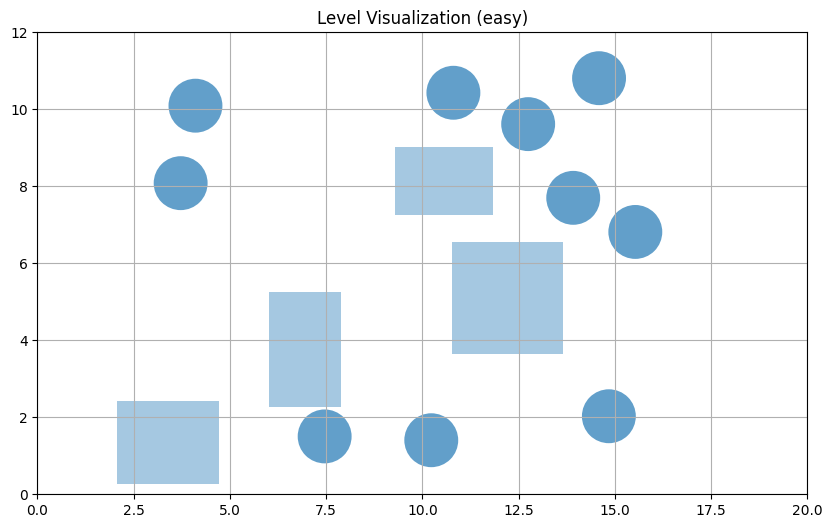

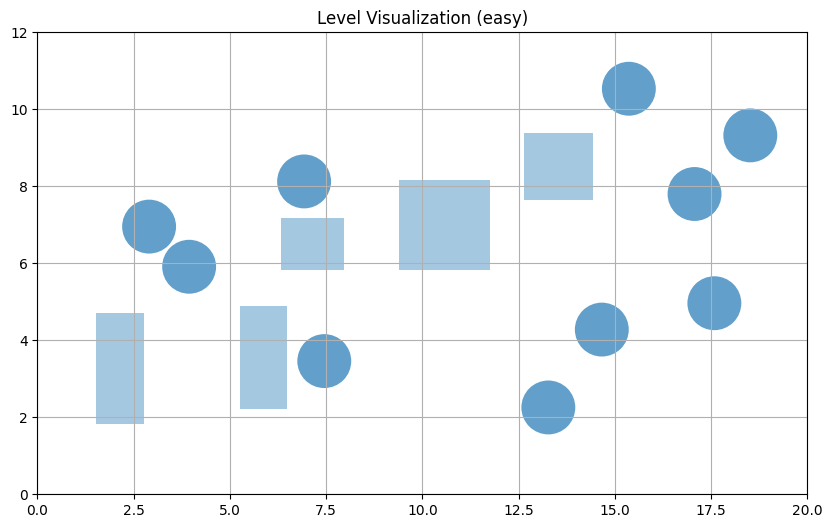

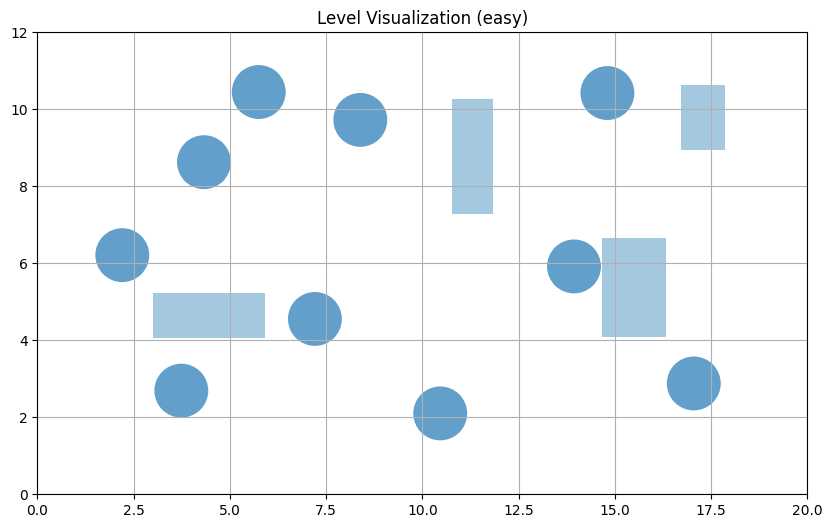

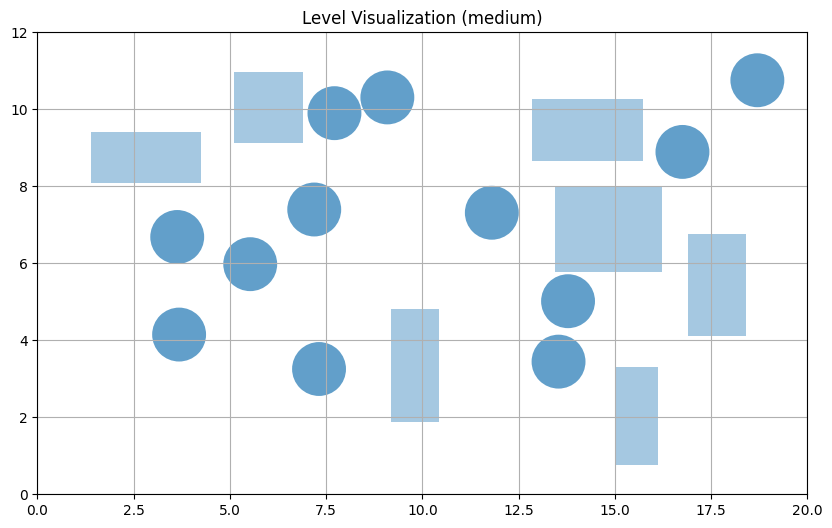

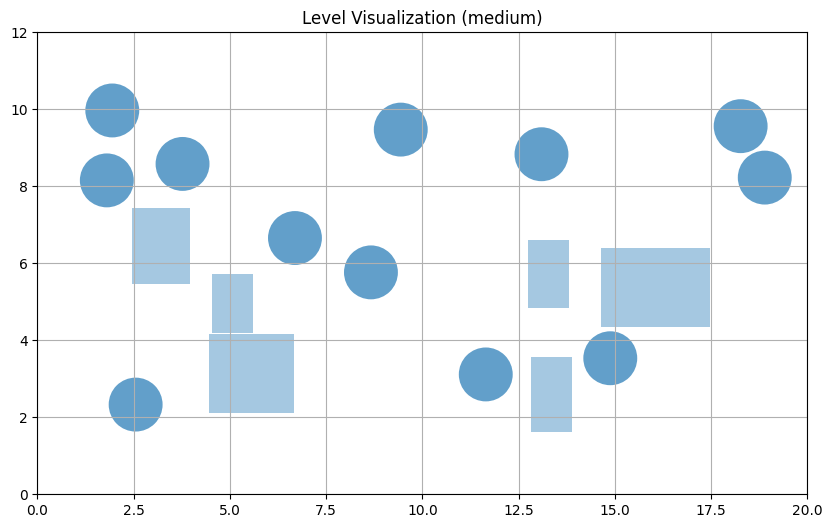

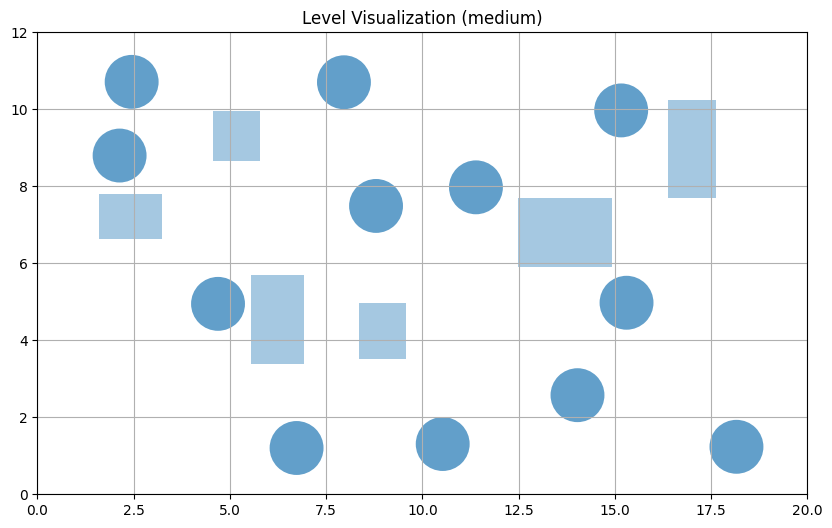

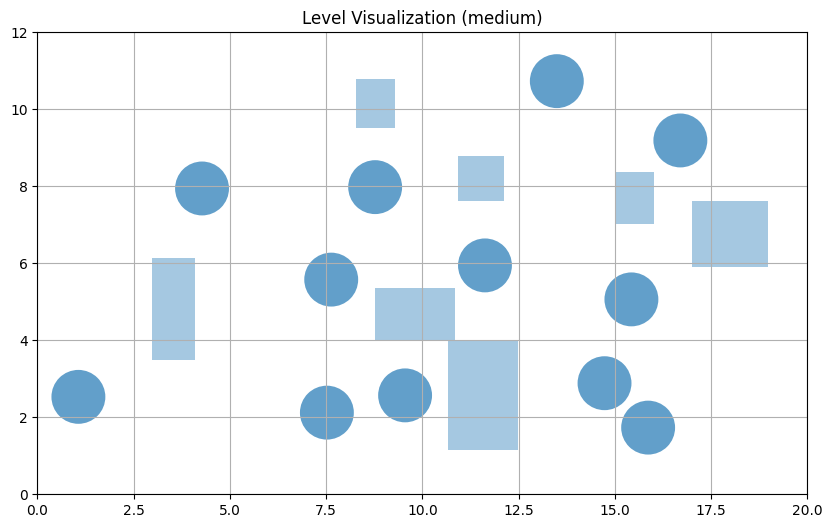

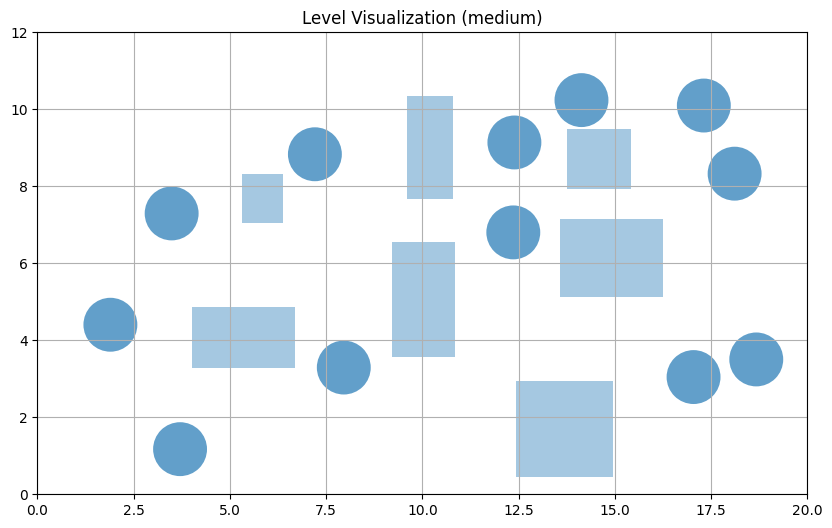

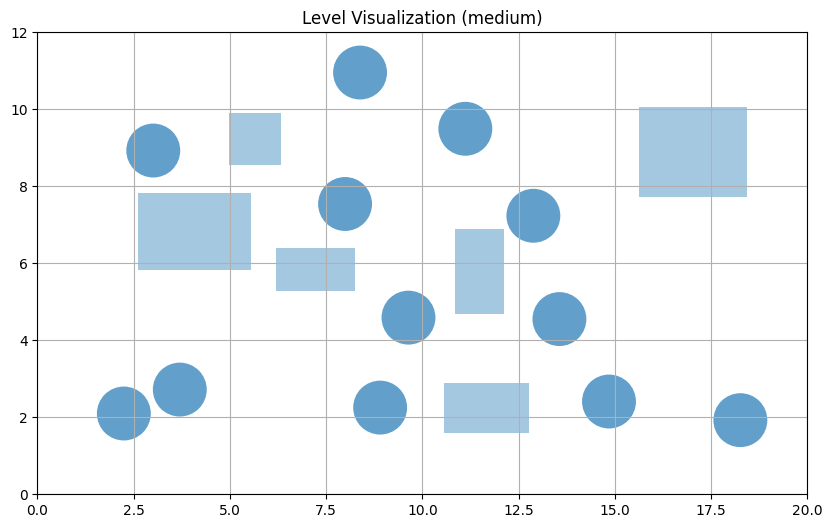

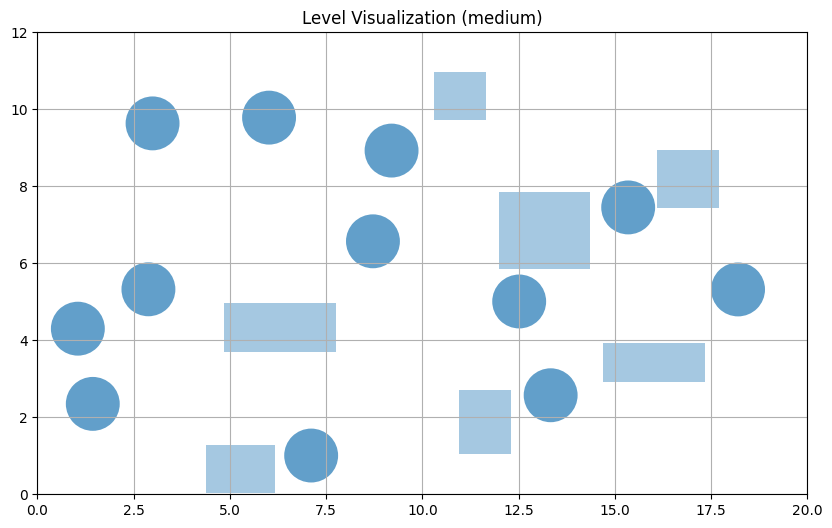

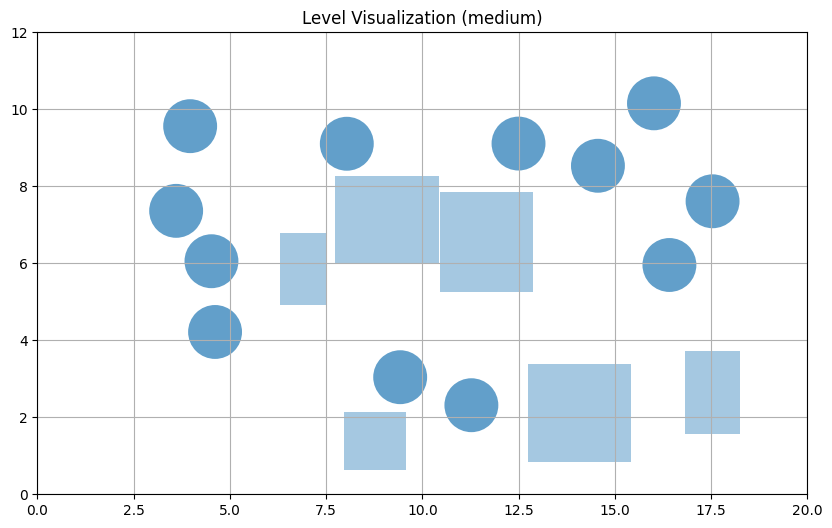

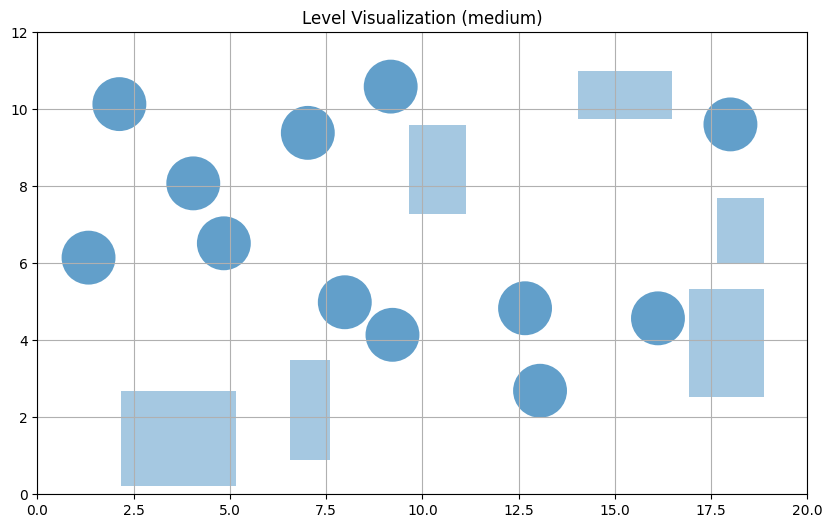

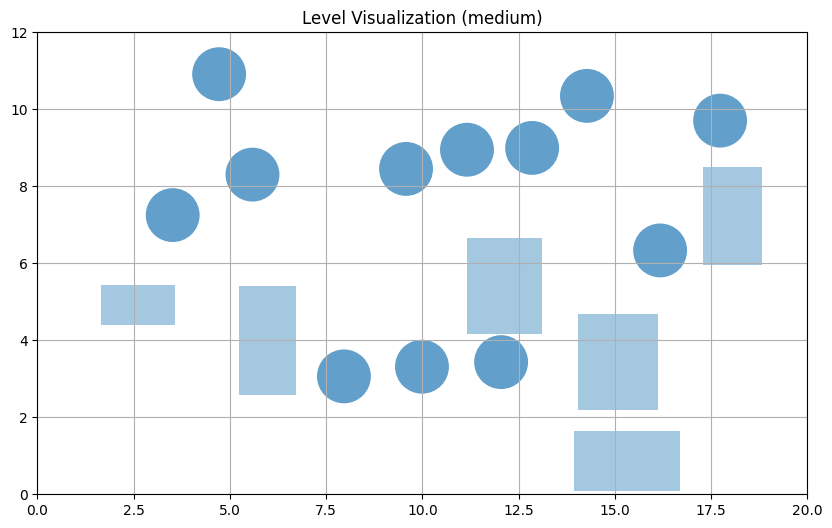

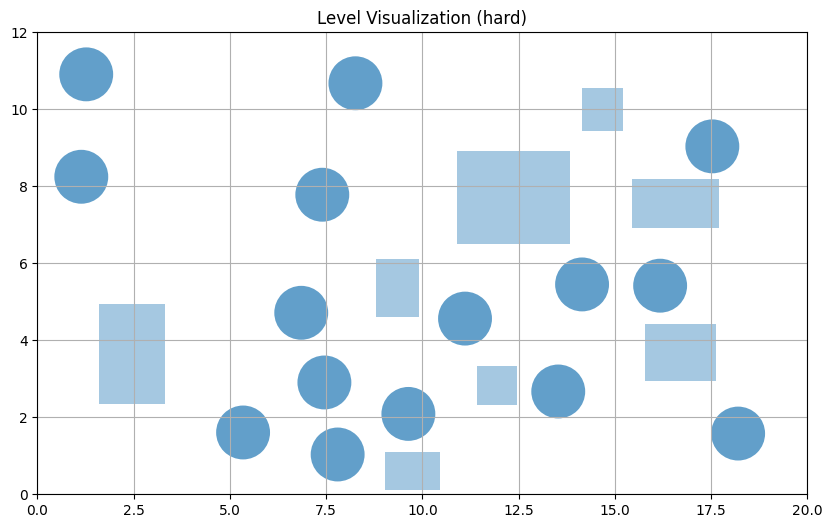

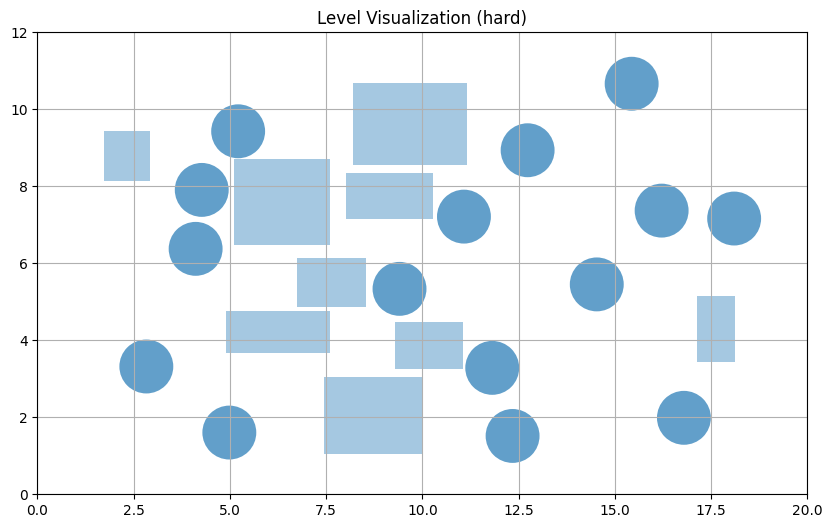

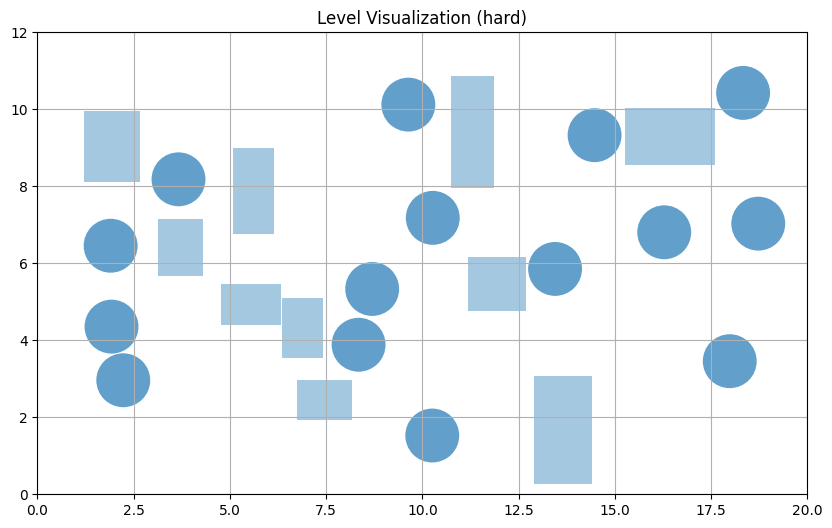

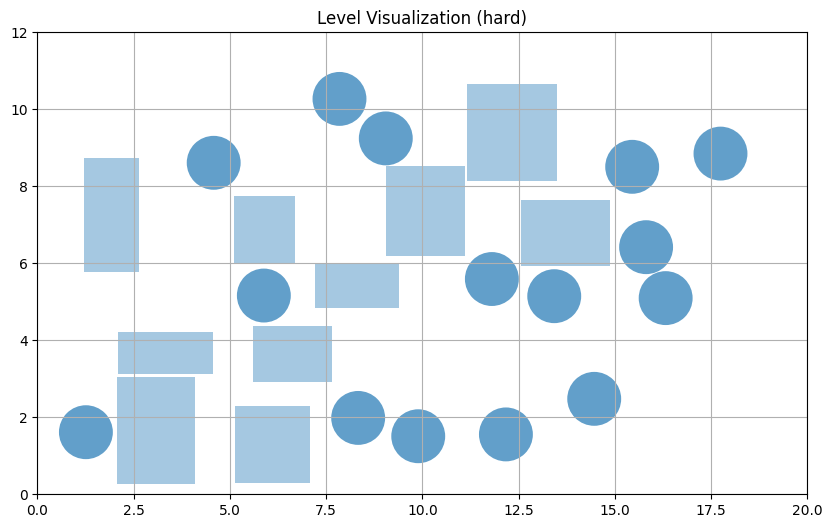

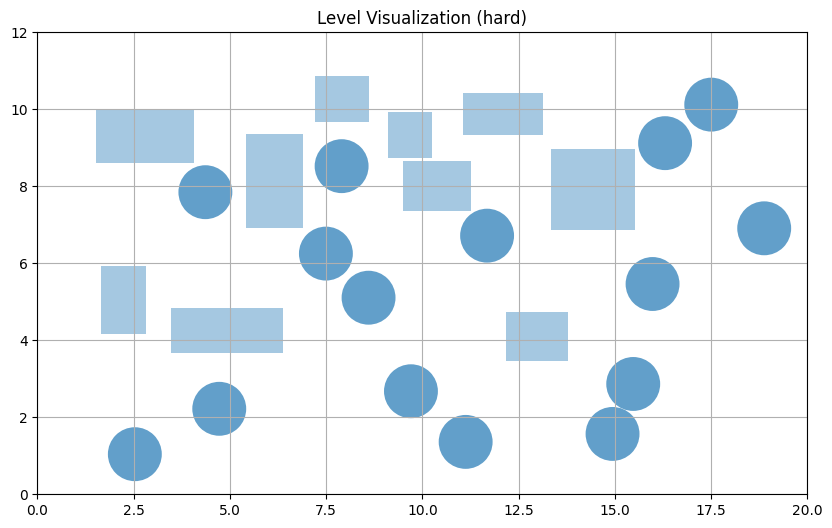

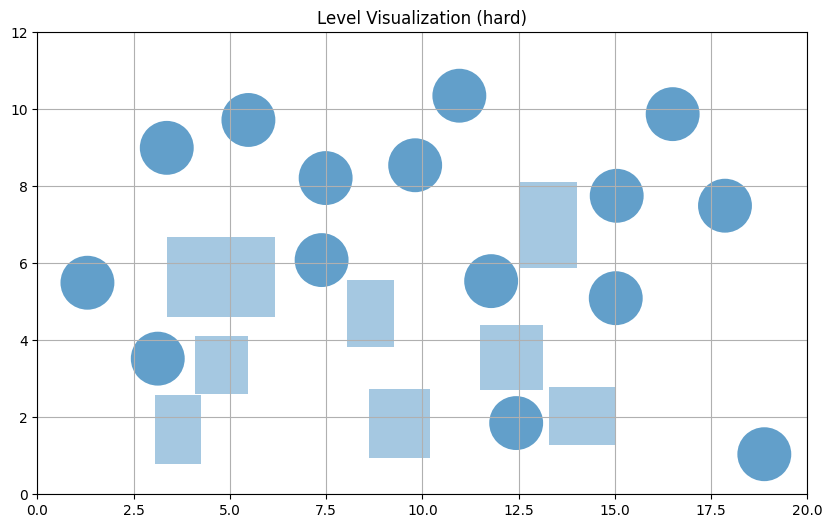

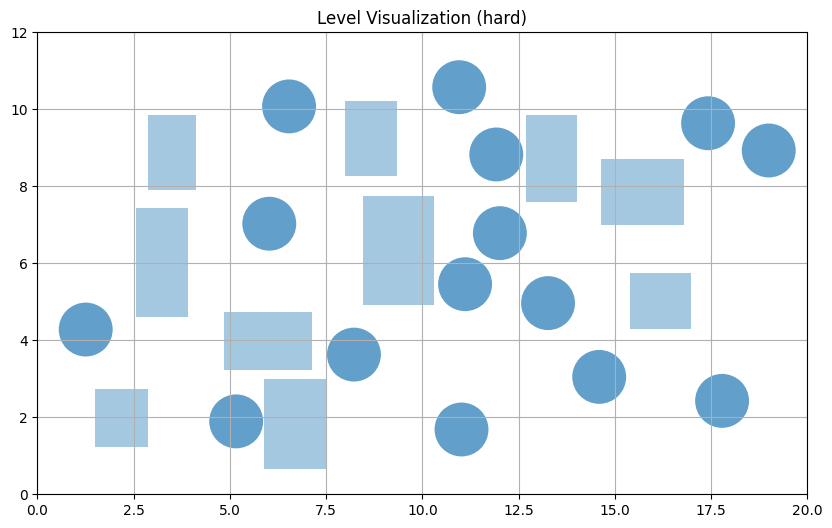

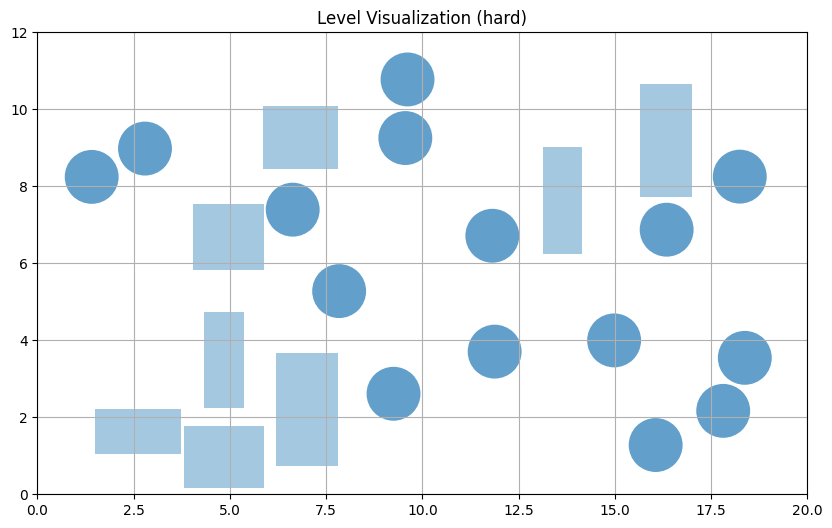

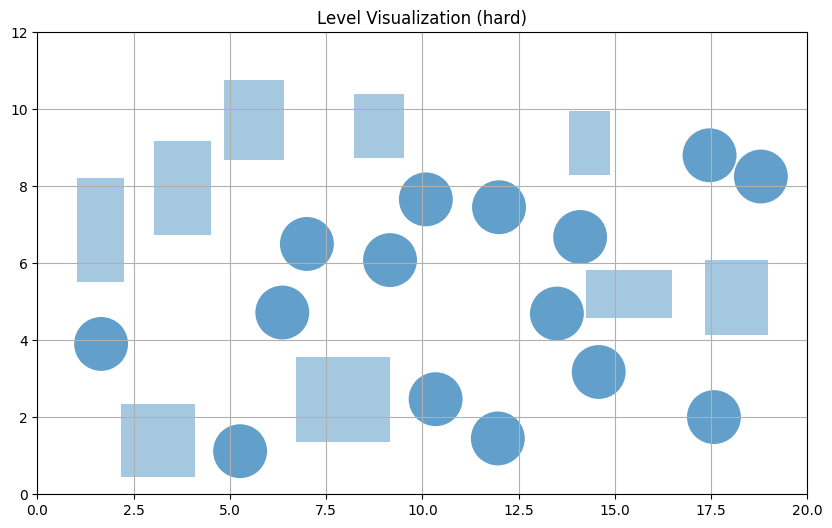

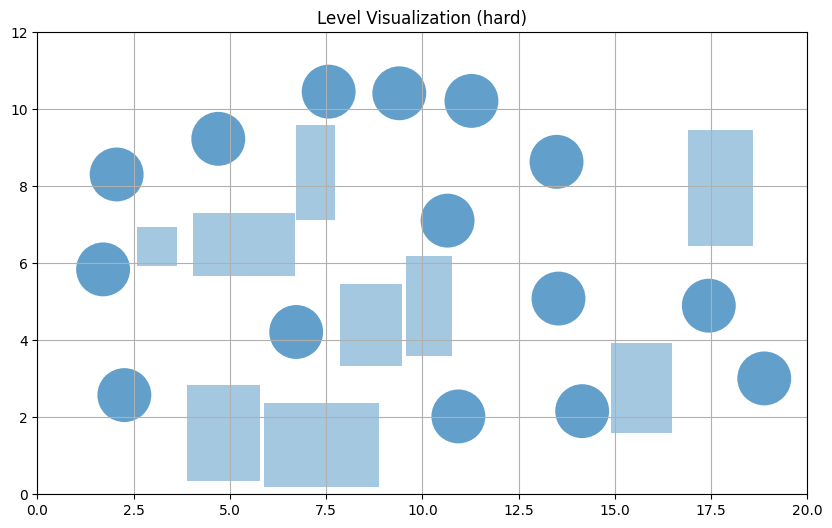

In [ ]:
LEVEL_WIDTH = 20
LEVEL_HEIGHT = 12

# -----------------------
# Overlap check functions
# -----------------------

def circle_circle_overlap(x1, y1, r1, x2, y2, r2):
    return math.dist((x1, y1), (x2, y2)) < (r1 + r2)

def rect_rect_overlap(x1, y1, w1, h1, x2, y2, w2, h2):
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def circle_rect_overlap(cx, cy, r, rx, ry, rw, rh):
    closest_x = max(rx, min(cx, rx + rw))
    closest_y = max(ry, min(cy, ry + rh))
    return math.dist((cx, cy), (closest_x, closest_y)) < r

# -----------------------
# Placement helper
# -----------------------
def place_pig(existing_pigs, blocks, radius=0.7):
    attempts = 0
    while attempts < 200:
        x = random.uniform(1, LEVEL_WIDTH - 1)
        y = random.uniform(1, LEVEL_HEIGHT - 1)

        valid = True
        for px, py, pr in existing_pigs:
            if circle_circle_overlap(x, y, radius, px, py, pr):
                valid = False
                break
        if not valid:
            attempts += 1
            continue

        for bx, by, bw, bh in blocks:
            if circle_rect_overlap(x, y, radius, bx, by, bw, bh):
                valid = False
                break

        if valid:
            return [x, y, radius]

        attempts += 1
    return None

def place_block(existing_pigs, existing_blocks):
    attempts = 0
    while attempts < 200:
        w = random.uniform(1, 3)
        h = random.uniform(1, 3)
        x = random.uniform(1, LEVEL_WIDTH - w - 1)
        y = random.uniform(0, LEVEL_HEIGHT - h - 1)

        valid = True
        for bx, by, bw, bh in existing_blocks:
            if rect_rect_overlap(x, y, w, h, bx, by, bw, bh):
                valid = False
                break
        if not valid:
            attempts += 1
            continue

        for px, py, pr in existing_pigs:
            if circle_rect_overlap(px, py, pr, x, y, w, h):
                valid = False
                break

        if valid:
            return [x, y, w, h]

        attempts += 1
    return None


# -----------------------
# Generate a level
# -----------------------
def generate_level(difficulty):
    params = {
        "easy":   {"birds": 5, "pigs": 10, "blocks": (4, 5)},
        "medium": {"birds": random.randint(4, 5), "pigs": 12, "blocks": (6, 7)},
        "hard":   {"birds": random.randint(3, 4), "pigs": 15, "blocks": (8,10)}
    }[difficulty]

    pigs = []
    blocks = []

    while len(pigs) < params["pigs"]:
        pig = place_pig(pigs, blocks)
        if pig: pigs.append(pig)

    num_blocks = random.randint(*params["blocks"])
    while len(blocks) < num_blocks:
        block = place_block(pigs, blocks)
        if block: blocks.append(block)

    return {
        "difficulty": difficulty,
        "birds": params["birds"],
        "pigs": pigs,
        "blocks": blocks
    }

# -----------------------
# Dataset Generation
# -----------------------
def generate_dataset():
    dataset = []
    for diff in ["easy", "medium", "hard"]:
        for _ in range(10):  # 3 levels per difficulty
            dataset.append(generate_level(diff))

    with open("angry_birds_levels.json", "w") as f:
        json.dump(dataset, f, indent=4)
    print("Dataset generated & saved → angry_birds_levels.json")

    return dataset

# -----------------------
# Visualization
# -----------------------
def visualize_level(level):
    fig, ax = plt.subplots(figsize=(12, 6))

    for x, y, r in level["pigs"]:
        circ = plt.Circle((x, y), r, fill=True, alpha=0.7)
        ax.add_patch(circ)

    for x, y, w, h in level["blocks"]:
        rect = plt.Rectangle((x, y), w, h, fill=True, alpha=0.4)
        ax.add_patch(rect)

    ax.set_xlim(0, LEVEL_WIDTH)
    ax.set_ylim(0, LEVEL_HEIGHT)
    ax.set_title(f"Level Visualization ({level['difficulty']})")
    ax.set_aspect('equal')
    plt.grid(True)
    plt.show()


# -----------
# Testing
# -----------
if __name__ == "__main__":
    dataset = generate_dataset()
    for i in range(len(dataset)):
      visualize_level(dataset[i])


## Simulator

In [ ]:
# -----------------------
# CONFIG for brute force
# -----------------------
DATASET_FILE = "angry_birds_levels.json"  
SUMMARY_CSV = "bruteforce_summary.csv"
SHOTS_CSV = "bruteforce_shots.csv"

G = 9.8
TIME_STEP = 0.05   # sampling resolution (s)
MAX_SIM_TIME = 8.0
SLINGSHOT_UNIT_BOX = (0.0, 0.0, 1.0, 1.0)  # release sampled in [0,1]x[0,1]
RANDOM_SEED = None  # set int for reproducible runs, or None

# Optional safety: limit permutations to avoid computation overtime
MAX_PERMUTATIONS_DEFAULT = 1000

In [ ]:
# -----------------------
# Geometry utilities
# -----------------------
def rect_contains_point(rx, ry, rw, rh, x, y):
    return (rx <= x <= rx + rw) and (ry <= y <= ry + rh)

def segment_intersects_rect(x1, y1, x2, y2, rx, ry, rw, rh):
    """
    Conservative segment-vs-axis-aligned-rect test via sampling points along the segment.
    This is robust and simple for our sampled trajectories.
    """
    seg_len = math.hypot(x2 - x1, y2 - y1)
    n = max(3, int(seg_len / 0.15))  # sample every ~0.15 units
    for i in range(n + 1):
        u = i / n
        x = x1 + (x2 - x1) * u
        y = y1 + (y2 - y1) * u
        if rect_contains_point(rx, ry, rw, rh, x, y):
            return True
    return False

def vertical_segment_blocked(px, y_low, y_high, blocks):
    """
    Check whether vertical open interval (y_low, y_high] at x=px intersects any block.
    If any block overlaps that vertical interval at px horizontally, it's blocked.
    """
    ymin, ymax = min(y_low, y_high), max(y_low, y_high)
    for (bx, by, bw, bh) in blocks:
        if bx <= px <= bx + bw:
            bmin, bmax = by, by + bh
            # If intervals overlap -> blocked
            if not (ymax < bmin or ymin > bmax):
                return True
    return False


# -----------------------
# Trajectory & simulator
# -----------------------
def compute_angle_velocity(start_pos, target):
    """
    Compute shot angle (radians) and velocity (float) from start -> target.
    start_pos: (x0, y0)
    target: (tx, ty, tr)
    Uses arctan2 for direction and a projectile-derived velocity formula with fallback.
    """
    x0, y0 = start_pos
    tx, ty, _ = target
    dx = tx - x0
    dy = ty - y0

    if abs(dx) < 1e-9 and abs(dy) < 1e-9:
        return 0.0, 0.0

    angle = math.atan2(dy, dx)

    cos_th = math.cos(angle)
    tan_th = math.tan(angle)

    # Analytic attempt for v^2
    denom = 2 * (dx * tan_th - dy) * (cos_th ** 2)
    if denom > 1e-9:
        v2 = (G * dx * dx) / denom
        if v2 > 0:
            v = math.sqrt(v2)
        else:
            v = math.sqrt(max(math.hypot(dx, dy) * G, 1.0))
    else:
        # fallback velocity proportional to distance
        v = math.sqrt(max(math.hypot(dx, dy) * G, 1.0))

    return angle, v

def trajectory_points(start_pos, angle, velocity, time_step=TIME_STEP):
    """Return list of (x,y,t) until ground or MAX_SIM_TIME."""
    x0, y0 = start_pos
    pts = []
    t = 0.0
    while t <= MAX_SIM_TIME:
        x = x0 + velocity * math.cos(angle) * t
        y = y0 + velocity * math.sin(angle) * t - 0.5 * G * t * t
        if y < 0:
            break
        pts.append((x, y, t))
        t += time_step
    return pts

def trajectory_y_at_x(start_pos, angle, velocity, x_query):
    """Analytic y at given x_query or None if unreachable/behind."""
    x0, y0 = start_pos
    cos_th = math.cos(angle)
    if abs(cos_th) < 1e-9:
        return None
    t = (x_query - x0) / (velocity * cos_th)
    if t < 0 or t > MAX_SIM_TIME:
        return None
    y = y0 + velocity * math.sin(angle) * t - 0.5 * G * t * t
    return y

def simulate_shot(start_pos, pigs, blocks, target_pig):
    """
    Simulate shot:
      - start_pos: (x,y)
      - pigs: list of (x,y,r) representing remaining pigs for this shot
      - blocks: list of (x,y,w,h)
      - target_pig: (tx,ty,tr) in ORIGINAL coordinates (value matched)
    Returns:
      destroyed_indices_in_remaining_pigs (list of indices),
      hit_block_flag (True/False),
      angle_deg, velocity
    Implements Option B rules:
      * If trajectory intersects a block -> bird stops and destroys NO pigs.
      * Else, a pig is destroyed if its bottom >= y_traj(px) AND vertical segment from y_traj to pig center is not blocked.
    """
    angle, v = compute_angle_velocity(start_pos, target_pig)
    if v <= 0:
        return [], True, math.degrees(angle), v

    pts = trajectory_points(start_pos, angle, v)
    if not pts:
        return [], True, math.degrees(angle), v

    # Check if any trajectory segment intersects any block
    hit_block = False
    for i in range(len(pts) - 1):
        x1, y1, _ = pts[i]
        x2, y2, _ = pts[i + 1]
        for (bx, by, bw, bh) in blocks:
            if segment_intersects_rect(x1, y1, x2, y2, bx, by, bw, bh):
                hit_block = True
                break
        if hit_block:
            break

    if hit_block:
        # Bird hit a block -> destroys no pigs
        return [], True, math.degrees(angle), v

    # Evaluate pigs: those above/touching trajectory and with vertical LOS
    destroyed = []
    for idx, (px, py, pr) in enumerate(pigs):
        y_traj = trajectory_y_at_x(start_pos, angle, v, px)
        if y_traj is None:
            continue
        pig_bottom = py - pr
        # pig bottom should be >= trajectory y (above or touching)
        if pig_bottom + 1e-9 >= y_traj:
            blocked = vertical_segment_blocked(px, y_traj, py, blocks)
            if not blocked:
                destroyed.append(idx)

    return destroyed, False, math.degrees(angle), v

## Brute Force

In [ ]:
# -----------------------
# Brute Force
# -----------------------
def map_destroyed_to_original(destroyed_indices, remaining_pigs, original_pigs):
    """
    Map indices in remaining_pigs -> original indices canonicalized.
    """
    mapped = []
    for d in destroyed_indices:
        pig = remaining_pigs[d]
        found = None
        for oi, op in enumerate(original_pigs):
            if (abs(op[0] - pig[0]) < 1e-6 and abs(op[1] - pig[1]) < 1e-6 and abs(op[2] - pig[2]) < 1e-6):
                found = oi
                break
        if found is None:
            # fallback: nearest by XY distance
            best, best_idx = 1e18, None
            for oi, op in enumerate(original_pigs):
                dpos = math.hypot(op[0] - pig[0], op[1] - pig[1])
                if dpos < best:
                    best = dpos
                    best_idx = oi
            found = best_idx
        mapped.append(found)
    return sorted(list(set(mapped)))

def try_sequence(level, perm, slingshot_box=(0.0,0.0,1.0,1.0)):
    """
    Try a particular permutation (ordered tuple of original pig indices).
    Returns:
      success_flag, shots_list, pigs_destroyed_count, birds_used, runtime_seq
    shots_list contains per-shot dicts with:
      bird_start_x,y, target_original_idx, angle_deg, velocity, hit_block, destroyed_original_indices
    """
    original_pigs = level["pigs"]
    blocks = level["blocks"]
    birds_total = level["birds"]

    remaining_pigs = [tuple(p) for p in original_pigs]  # (x,y,r)
    destroyed_original = set()
    shots = []
    birds_left = birds_total
    start_seq = time.time()

    for target_orig_idx in perm:
        if birds_left <= 0 or len(remaining_pigs) == 0:
            break
        if target_orig_idx in destroyed_original:
            continue

        target_pig = tuple(original_pigs[target_orig_idx])

        # sample release in [xmin,xmax]x[ymin,ymax]
        xmin, ymin, xmax, ymax = slingshot_box
        bird_start = (random.uniform(xmin, xmax), random.uniform(ymin, ymax))

        destroyed_rel, hit_block, angle_deg, velocity = simulate_shot(bird_start, remaining_pigs, blocks, target_pig)

        destroyed_orig_list = map_destroyed_to_original(destroyed_rel, remaining_pigs, original_pigs)

        # If bird hit block -> per rule destroyed none
        if hit_block:
            destroyed_rel = []
            destroyed_orig_list = []

        shots.append({
            "bird_start_x": bird_start[0],
            "bird_start_y": bird_start[1],
            "target_original_idx": target_orig_idx,
            "angle_deg": angle_deg,
            "velocity": velocity,
            "hit_block": hit_block,
            "destroyed_original_indices": destroyed_orig_list
        })

        # remove destroyed from remaining_pigs using relative indices (descending pop)
        if destroyed_rel:
            for dr in sorted(destroyed_rel, reverse=True):
                if 0 <= dr < len(remaining_pigs):
                    remaining_pigs.pop(dr)
            destroyed_original.update(destroyed_orig_list)

        birds_left -= 1

        if len(destroyed_original) == len(original_pigs):
            runtime_seq = time.time() - start_seq
            return True, shots, len(destroyed_original), birds_total - birds_left, runtime_seq

    runtime_seq = time.time() - start_seq
    return False, shots, len(destroyed_original), birds_total - birds_left, runtime_seq


# -----------------------
# Brute-force search over permutations
# -----------------------
def brute_force_level(level, max_permutations=None, slingshot_box=(0.0,0.0,1.0,1.0)):
    """
    Try permutations of original pig indices. Return best found (success or best partial).
    """
    n = len(level["pigs"])
    pig_indices = list(range(n))
    best = {
        "success": False,
        "pigs_destroyed": 0,
        "shots_used": None,
        "shots_seq": None,
        "runtime_seq": None,
        "permutations_tried": 0
    }

    start_all = time.time()
    perm_gen = itertools.permutations(pig_indices)
    if max_permutations:
        perm_gen = islice(perm_gen, max_permutations)

    for perm in perm_gen:
        best["permutations_tried"] += 1
        success, shots, pigs_destroyed, shots_used, runtime_seq = try_sequence(level, perm, slingshot_box)
        if pigs_destroyed > best["pigs_destroyed"]:
            best.update({
                "pigs_destroyed": pigs_destroyed,
                "shots_used": shots_used,
                "shots_seq": shots,
                "runtime_seq": runtime_seq
            })
        if success:
            best.update({
                "success": True,
                "pigs_destroyed": pigs_destroyed,
                "shots_used": shots_used,
                "shots_seq": shots,
                "runtime_seq": runtime_seq
            })
            break

    best["total_runtime"] = time.time() - start_all
    return best

In [ ]:
# -----------------------
# CSV Logging
# -----------------------
def run_bruteforce_all(dataset_file=DATASET_FILE, max_permutations=MAX_PERMUTATIONS_DEFAULT, slingshot_box=(0.0,0.0,1.0,1.0), random_seed=None):
    if random_seed is not None:
        random.seed(random_seed)
    with open(dataset_file, "r") as f:
        levels = json.load(f)

    summary_rows = []
    shots_rows = []

    for li, level in enumerate(levels):
        print(f"Running level {li} (difficulty={level.get('difficulty','')}) pigs={len(level['pigs'])} birds={level['birds']}")
        res = brute_force_level(level, max_permutations=max_permutations, slingshot_box=slingshot_box)
        print(f"  -> success={res['success']}, destroyed={res['pigs_destroyed']}/{len(level['pigs'])}, perms_tried={res['permutations_tried']}, total_time={res['total_runtime']:.2f}s")
        summary_rows.append({
            "level_index": li,
            "difficulty": level.get("difficulty", ""),
            "total_pigs": len(level["pigs"]),
            "birds": level["birds"],
            "success": res["success"],
            "pigs_destroyed": res["pigs_destroyed"],
            "shots_used": res["shots_used"] if res["shots_used"] is not None else "",
            "permutations_tried": res["permutations_tried"],
            "total_runtime": res["total_runtime"],
            "runtime_for_solution": res.get("runtime_seq", "")
        })

        if res["shots_seq"]:
            for si, s in enumerate(res["shots_seq"]):
                shots_rows.append({
                    "level_index": li,
                    "shot_index": si,
                    "bird_start_x": s["bird_start_x"],
                    "bird_start_y": s["bird_start_y"],
                    "target_original_idx": s["target_original_idx"],
                    "angle_deg": s["angle_deg"],
                    "velocity": s["velocity"],
                    "hit_block": s["hit_block"],
                    "destroyed_original_indices": "|".join(str(x) for x in s["destroyed_original_indices"])
                })

    # write summary CSV
    with open(SUMMARY_CSV, "w", newline="") as f:
        fieldnames = ["level_index","difficulty","total_pigs","birds","success","pigs_destroyed","shots_used","permutations_tried","total_runtime","runtime_for_solution"]
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for r in summary_rows:
            writer.writerow(r)
    print(f"Saved summary CSV -> {SUMMARY_CSV}")

    # write shots CSV
    with open(SHOTS_CSV, "w", newline="") as f:
        fieldnames = ["level_index","shot_index","bird_start_x","bird_start_y","target_original_idx","angle_deg","velocity","hit_block","destroyed_original_indices"]
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for r in shots_rows:
            writer.writerow(r)
    print(f"Saved shots CSV -> {SHOTS_CSV}")

    return summary_rows, shots_rows


# -----------------------
# Run as script in Colab cell
# -----------------------
if __name__ == "__main__":
    if RANDOM_SEED is not None:
        rs = RANDOM_SEED
    else:
        rs = None
    # safe default: keep full brute-force None for small levels; set a limit if we have many pigs
    MAX_PERM = MAX_PERMUTATIONS_DEFAULT
    run_bruteforce_all(dataset_file=DATASET_FILE, max_permutations=MAX_PERM, slingshot_box=SLINGSHOT_UNIT_BOX, random_seed=rs)


Running level 0 (difficulty=easy) pigs=10 birds=5
  -> success=False, destroyed=8/10, perms_tried=1000, total_time=0.44s
Running level 1 (difficulty=easy) pigs=10 birds=5
  -> success=False, destroyed=8/10, perms_tried=1000, total_time=0.13s
Running level 2 (difficulty=easy) pigs=10 birds=5
  -> success=False, destroyed=9/10, perms_tried=1000, total_time=0.43s
Running level 3 (difficulty=easy) pigs=10 birds=5
  -> success=False, destroyed=6/10, perms_tried=1000, total_time=0.66s
Running level 4 (difficulty=easy) pigs=10 birds=5
  -> success=False, destroyed=8/10, perms_tried=1000, total_time=1.23s
Running level 5 (difficulty=easy) pigs=10 birds=5
  -> success=False, destroyed=9/10, perms_tried=1000, total_time=1.13s
Running level 6 (difficulty=easy) pigs=10 birds=5
  -> success=False, destroyed=9/10, perms_tried=1000, total_time=0.56s
Running level 7 (difficulty=easy) pigs=10 birds=5
  -> success=False, destroyed=8/10, perms_tried=1000, total_time=0.20s
Running level 8 (difficulty=easy

## Piotrowski Heuristic

In [ ]:
# -----------------------
# CONFIG for pitrowski heuristic
# -----------------------
DATASET_FILE = "angry_birds_levels.json" 
SUMMARY_CSV = "heuristic_summary.csv"
SHOTS_CSV = "heuristic_shots.csv"
G = 9.8
TIME_STEP = 0.05
MAX_SIM_TIME = 8.0
SLINGSHOT_UNIT_BOX = (0.0,0.0,1.0,1.0)
RANDOM_SEED = None

# -----------------------
# Piotrowski Heuristic
# -----------------------
def heuristic_solver(level):
    pigs = [tuple(p) for p in level["pigs"]]
    blocks = level["blocks"]
    birds_total = level["birds"]
    shots=[]
    destroyed_total=set()
    birds_left = birds_total
    start_time = time.time()

    while birds_left>0 and len(destroyed_total)<len(pigs):
        # Evaluate all remaining pigs and choose pig that maximizes destroyed pigs
        best_pig_idx=None
        best_destroyed=[]
        best_start=(0,0)
        best_angle=0
        best_vel=0
        for idx, pig in enumerate(pigs):
            if idx in destroyed_total: continue
            # sample one start for FBHS
            xmin,ymin,xmax,ymax = SLINGSHOT_UNIT_BOX
            start_pos = (random.uniform(xmin,xmax), random.uniform(ymin,ymax))
            destroyed_rel, hit_block, angle_deg, v = simulate_shot(start_pos, pigs, blocks, pig)
            if hit_block: destroyed_rel=[]
            if len(destroyed_rel)>len(best_destroyed):
                best_destroyed=destroyed_rel
                best_pig_idx=idx
                best_start=start_pos
                best_angle=angle_deg
                best_vel=v
        if not best_destroyed and best_pig_idx is None:
            # fallback: pick first remaining pig randomly
            remaining=[i for i in range(len(pigs)) if i not in destroyed_total]
            best_pig_idx=random.choice(remaining)
            xmin,ymin,xmax,ymax = SLINGSHOT_UNIT_BOX
            best_start=(random.uniform(xmin,xmax), random.uniform(ymin,ymax))
            _, _, best_angle, best_vel = simulate_shot(best_start, pigs, blocks, pigs[best_pig_idx])
            best_destroyed=[]
        shots.append({
            "bird_start_x": best_start[0],
            "bird_start_y": best_start[1],
            "target_original_idx": best_pig_idx,
            "angle_deg": best_angle,
            "velocity": best_vel,
            "destroyed_original_indices": best_destroyed
        })
        destroyed_total.update(best_destroyed)
        birds_left-=1

    runtime_total = time.time()-start_time
    success = len(destroyed_total)==len(pigs)
    return shots, success, len(destroyed_total), birds_total-birds_left, runtime_total

# -----------------------
# CSV Logger
# -----------------------
def run_heuristic_all(dataset_file=DATASET_FILE, random_seed=None):
    if random_seed is not None: random.seed(random_seed)
    with open(dataset_file,"r") as f:
        levels=json.load(f)
    summary_rows=[]
    shots_rows=[]
    for li,level in enumerate(levels):
        print(f"Running level {li} (difficulty={level.get('difficulty','')}) pigs={len(level['pigs'])} birds={level['birds']}")
        shots, success, pigs_destroyed, shots_used, runtime_total = heuristic_solver(level)
        print(f" -> success={success}, destroyed={pigs_destroyed}/{len(level['pigs'])}, shots_used={shots_used}, runtime={runtime_total:.2f}s")
        summary_rows.append({
            "level_index": li,
            "difficulty": level.get("difficulty",""),
            "total_pigs": len(level["pigs"]),
            "birds": level["birds"],
            "success": success,
            "pigs_destroyed": pigs_destroyed,
            "shots_used": shots_used,
            "runtime_total": runtime_total
        })
        for si,s in enumerate(shots):
            shots_rows.append({
                "level_index": li,
                "shot_index": si,
                "bird_start_x": s["bird_start_x"],
                "bird_start_y": s["bird_start_y"],
                "target_original_idx": s["target_original_idx"],
                "angle_deg": s["angle_deg"],
                "velocity": s["velocity"],
                "destroyed_original_indices": "|".join(str(x) for x in s["destroyed_original_indices"])
            })
    # write CSVs
    with open(SUMMARY_CSV,"w",newline="") as f:
        fn=["level_index","difficulty","total_pigs","birds","success","pigs_destroyed","shots_used","runtime_total"]
        writer=csv.DictWriter(f,fieldnames=fn)
        writer.writeheader()
        for r in summary_rows: writer.writerow(r)
    with open(SHOTS_CSV,"w",newline="") as f:
        fn=["level_index","shot_index","bird_start_x","bird_start_y","target_original_idx","angle_deg","velocity","destroyed_original_indices"]
        writer=csv.DictWriter(f,fieldnames=fn)
        writer.writeheader()
        for r in shots_rows: writer.writerow(r)
    print(f"Saved summary CSV -> {SUMMARY_CSV}")
    print(f"Saved shots CSV -> {SHOTS_CSV}")
    return summary_rows, shots_rows

# -----------------------
# Run example
# -----------------------
if __name__=="__main__":
    run_heuristic_all(random_seed=RANDOM_SEED)


Running level 0 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=8/10, shots_used=5, runtime=0.00s
Running level 1 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=0/10, shots_used=5, runtime=0.00s
Running level 2 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=9/10, shots_used=5, runtime=0.00s
Running level 3 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=6/10, shots_used=5, runtime=0.00s
Running level 4 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=8/10, shots_used=5, runtime=0.00s
Running level 5 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=9/10, shots_used=5, runtime=0.00s
Running level 6 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=9/10, shots_used=5, runtime=0.00s
Running level 7 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=8/10, shots_used=5, runtime=0.00s
Running level 8 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=9/10, shots_used=

## Genetic Algorithm

In [ ]:
# -----------------------
# CONFIG for GA heuristic
# -----------------------
DATASET_FILE = "angry_birds_levels.json"
SUMMARY_CSV = "ga_summary.csv"
SHOTS_CSV = "ga_shots.csv"
G = 9.8
TIME_STEP = 0.05
MAX_SIM_TIME = 8.0
SLINGSHOT_UNIT_BOX = (0.0,0.0,1.0,1.0)
RANDOM_SEED = None

# -----------------------
# GA COMPONENT
# -----------------------
def initialize_population(pop_size, birds_total):
    return [[(random.uniform(0,1), random.uniform(0,1)) for _ in range(birds_total)] for _ in range(pop_size)]

def fitness(individual, pigs, blocks):
    destroyed_total=set()
    for i,start_pos in enumerate(individual):
        # target pig = first remaining pig
        remaining = [idx for idx in range(len(pigs)) if idx not in destroyed_total]
        if not remaining: break
        target = pigs[random.choice(remaining)]
        destroyed, hit_block, _, _ = simulate_shot(start_pos, pigs, blocks, target)
        if hit_block: destroyed=[]
        destroyed_total.update(destroyed)
    return len(destroyed_total), destroyed_total

def selection(pop, scores):
    total = sum(scores)
    if total==0: return random.choice(pop)
    pick=random.uniform(0,total)
    current=0
    for ind,score in zip(pop,scores):
        current+=score
        if current>=pick: return ind
    return random.choice(pop)

def crossover(parent1, parent2):
    point = random.randint(1, len(parent1)-1)
    child = parent1[:point]+parent2[point:]
    return child

def mutate(ind, mutation_rate=0.1):
    child = []
    for x,y in ind:
        if random.random()<mutation_rate:
            x = min(max(x+random.uniform(-0.1,0.1),0.0),1.0)
            y = min(max(y+random.uniform(-0.1,0.1),0.0),1.0)
        child.append((x,y))
    return child

def ga_solver(level, pop_size=30, generations=25, mutation_rate=0.15):
    pigs = [tuple(p) for p in level["pigs"]]
    blocks = level["blocks"]
    birds_total = level["birds"]

    pop = initialize_population(pop_size, birds_total)
    best_individual = None
    best_score = -1
    best_destroyed = set()
    start_time = time.time()

    for g in range(generations):
        scores=[]
        destroyed_list=[]
        for ind in pop:
            score,destroyed = fitness(ind, pigs, blocks)
            scores.append(score)
            destroyed_list.append(destroyed)
            if score>best_score:
                best_score=score
                best_individual=ind
                best_destroyed=destroyed
        # create next generation
        new_pop=[]
        for _ in range(pop_size):
            p1 = selection(pop, scores)
            p2 = selection(pop, scores)
            child = crossover(p1,p2)
            child = mutate(child, mutation_rate)
            new_pop.append(child)
        pop = new_pop

    # simulate best_individual for shot details
    shots=[]
    destroyed_total=set()
    for i,start_pos in enumerate(best_individual):
        remaining = [idx for idx in range(len(pigs)) if idx not in destroyed_total]
        if not remaining: break
        target = pigs[random.choice(remaining)]
        destroyed, hit_block, angle_deg, vel = simulate_shot(start_pos, pigs, blocks, target)
        if hit_block: destroyed=[]
        destroyed_total.update(destroyed)
        shots.append({
            "bird_start_x": start_pos[0],
            "bird_start_y": start_pos[1],
            "target_original_idx": pigs.index(target),
            "angle_deg": angle_deg,
            "velocity": vel,
            "destroyed_original_indices": list(destroyed)
        })
    runtime_total = time.time()-start_time
    success = len(destroyed_total)==len(pigs)
    return shots, success, len(destroyed_total), birds_total, runtime_total

# -----------------------
# CSV LOGGING
# -----------------------
def run_ga_all(dataset_file=DATASET_FILE, pop_size=30, generations=25, mutation_rate=0.15, random_seed=None):
    if random_seed is not None: random.seed(random_seed)
    with open(dataset_file,"r") as f:
        levels=json.load(f)
    summary_rows=[]
    shots_rows=[]
    for li,level in enumerate(levels):
        print(f"Running level {li} (difficulty={level.get('difficulty','')}) pigs={len(level['pigs'])} birds={level['birds']}")
        shots, success, pigs_destroyed, birds_total, runtime_total = ga_solver(level, pop_size, generations, mutation_rate)
        print(f" -> success={success}, destroyed={pigs_destroyed}/{len(level['pigs'])}, runtime={runtime_total:.2f}s")
        summary_rows.append({
            "level_index": li,
            "difficulty": level.get("difficulty",""),
            "total_pigs": len(level["pigs"]),
            "birds": level["birds"],
            "success": success,
            "pigs_destroyed": pigs_destroyed,
            "birds_used": birds_total,
            "runtime_total": runtime_total
        })
        for si,s in enumerate(shots):
            shots_rows.append({
                "level_index": li,
                "shot_index": si,
                "bird_start_x": s["bird_start_x"],
                "bird_start_y": s["bird_start_y"],
                "target_original_idx": s["target_original_idx"],
                "angle_deg": s["angle_deg"],
                "velocity": s["velocity"],
                "destroyed_original_indices": "|".join(str(x) for x in s["destroyed_original_indices"])
            })
    # write CSVs
    with open(SUMMARY_CSV,"w",newline="") as f:
        fn=["level_index","difficulty","total_pigs","birds","success","pigs_destroyed","birds_used","runtime_total"]
        writer=csv.DictWriter(f,fieldnames=fn)
        writer.writeheader()
        for r in summary_rows: writer.writerow(r)
    with open(SHOTS_CSV,"w",newline="") as f:
        fn=["level_index","shot_index","bird_start_x","bird_start_y","target_original_idx","angle_deg","velocity","destroyed_original_indices"]
        writer=csv.DictWriter(f,fieldnames=fn)
        writer.writeheader()
        for r in shots_rows: writer.writerow(r)
    print(f"Saved summary CSV -> {SUMMARY_CSV}")
    print(f"Saved shots CSV -> {SHOTS_CSV}")
    return summary_rows, shots_rows

# -----------------------
# Run example
# -----------------------
if __name__=="__main__":
    run_ga_all(random_seed=RANDOM_SEED)


Running level 0 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=8/10, runtime=0.63s
Running level 1 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=0/10, runtime=0.11s
Running level 2 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=8/10, runtime=0.74s
Running level 3 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=6/10, runtime=0.37s
Running level 4 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=8/10, runtime=0.61s
Running level 5 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=9/10, runtime=0.70s
Running level 6 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=0/10, runtime=0.45s
Running level 7 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=8/10, runtime=0.25s
Running level 8 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=9/10, runtime=0.27s
Running level 9 (difficulty=easy) pigs=10 birds=5
 -> success=False, destroyed=7/10, runtime=0.50s
Running le

## Graphs for report

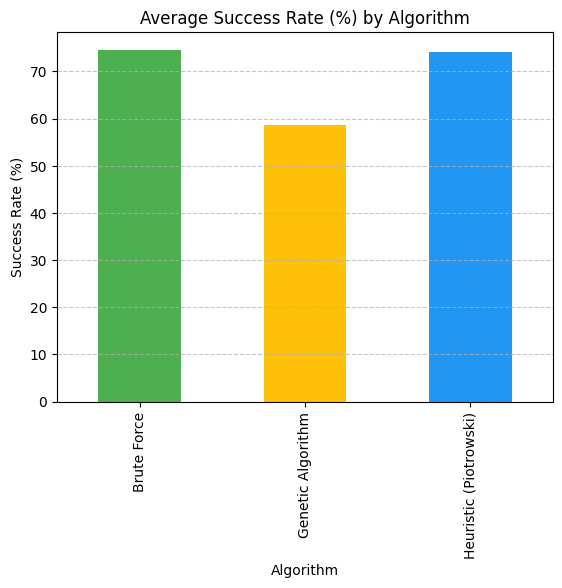

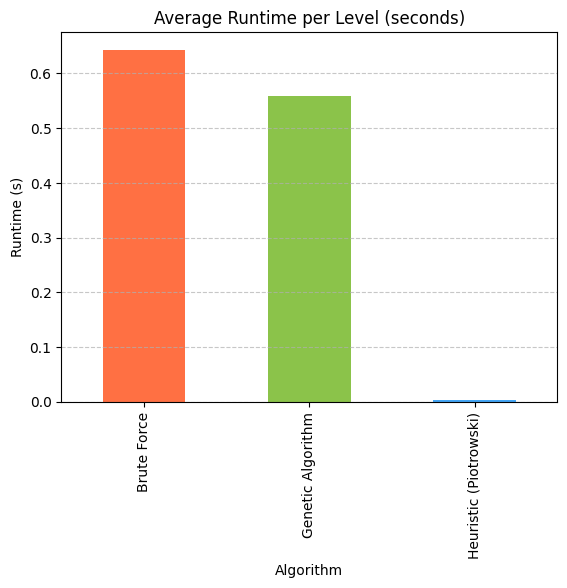

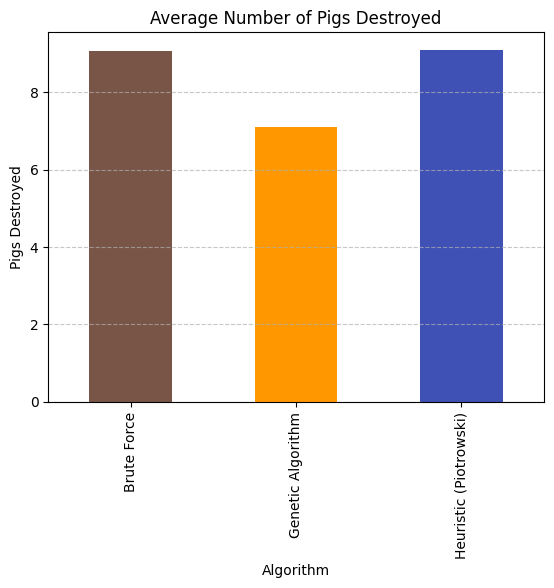

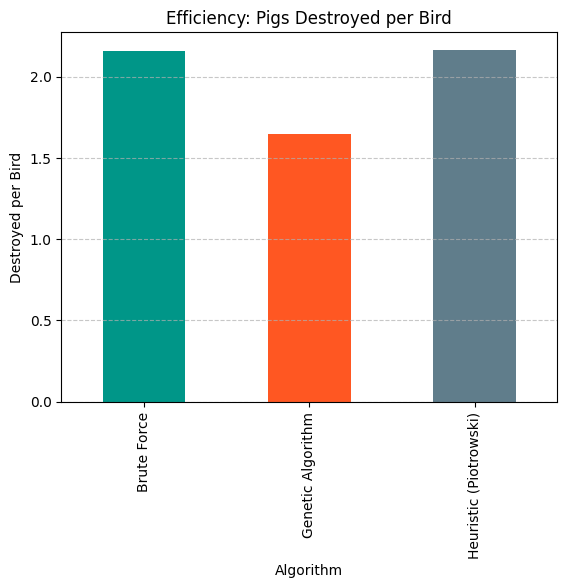

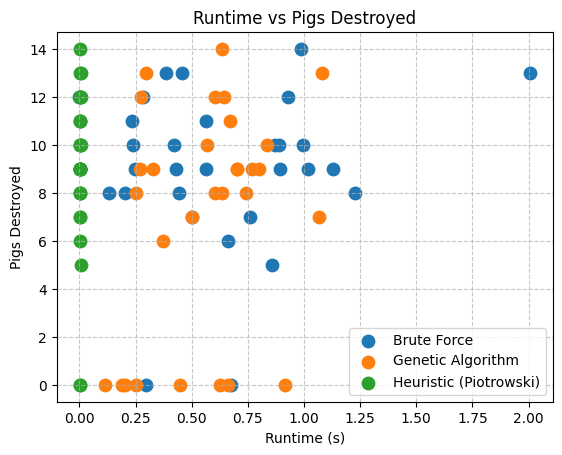

<Figure size 640x480 with 0 Axes>

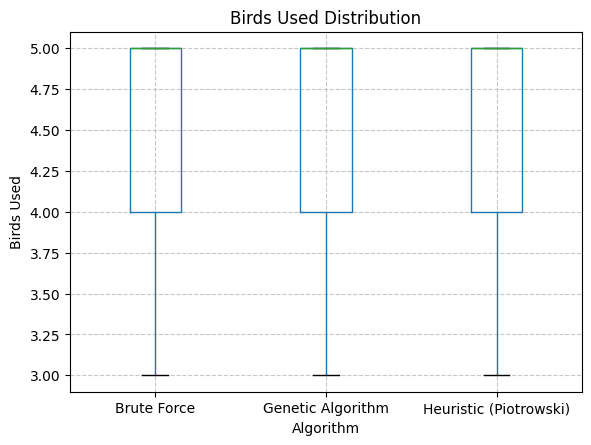

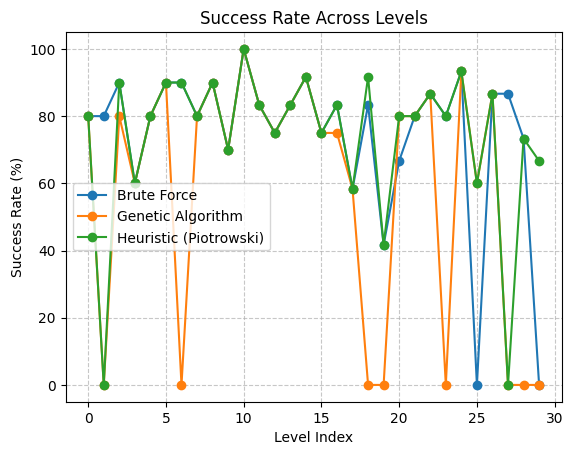


===== Algorithm Performance Summary =====
                        pigs_destroyed  birds_used  success_rate  \
algorithm                                                          
Brute Force                      9.067         4.4         0.746   
Genetic Algorithm                7.100         4.4         0.586   
Heuristic (Piotrowski)           9.100         4.4         0.740   

                        runtime_total  efficiency  runtime_per_bird  
algorithm                                                            
Brute Force                     0.644       2.157             0.151  
Genetic Algorithm               0.559       1.647             0.129  
Heuristic (Piotrowski)          0.004       2.166             0.001  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CSVs
brute = pd.read_csv("bruteforce_summary.csv")
heur = pd.read_csv("heuristic_summary.csv")
ga = pd.read_csv("ga_summary.csv")

def safe_rename(df, old_name, new_name):
    if old_name in df.columns and new_name not in df.columns:
        df.rename(columns={old_name: new_name}, inplace=True)

# Normalize column names safely
safe_rename(brute, 'total_runtime', 'runtime_total')
safe_rename(brute, 'birds', 'birds_used')

safe_rename(heur, 'birds', 'birds_used')
safe_rename(heur, 'runtime_total', 'runtime_total')  # safe no-op

safe_rename(ga, 'birds', 'birds_used')

# Add algorithm labels
brute['algorithm'] = 'Brute Force'
heur['algorithm'] = 'Heuristic (Piotrowski)'
ga['algorithm'] = 'Genetic Algorithm'

# Combine
data = pd.concat([brute, heur, ga], ignore_index=True)


# ---------- Compute Derived Metrics ----------
data['success_rate'] = data['pigs_destroyed'] / data['total_pigs']
data['efficiency'] = data['pigs_destroyed'] / data['birds_used']
data['runtime_per_bird'] = data['runtime_total'] / data['birds_used']

# Group averages by algorithm
group = data.groupby('algorithm').mean(numeric_only=True)


# ===============================================================
# 1. Success Rate Comparison
# ===============================================================
plt.figure()
(group['success_rate'] * 100).plot(kind='bar', color=['#4CAF50', '#FFC107', '#2196F3'])
plt.title('Average Success Rate (%) by Algorithm')
plt.ylabel('Success Rate (%)')
plt.xlabel('Algorithm')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# ===============================================================
# 2. Average Runtime per Level
# ===============================================================
plt.figure()
group['runtime_total'].plot(kind='bar', color=['#FF7043', '#8BC34A', '#42A5F5'])
plt.title('Average Runtime per Level (seconds)')
plt.ylabel('Runtime (s)')
plt.xlabel('Algorithm')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# ===============================================================
# 3. Average Pigs Destroyed per Level
# ===============================================================
plt.figure()
group['pigs_destroyed'].plot(kind='bar', color=['#795548', '#FF9800', '#3F51B5'])
plt.title('Average Number of Pigs Destroyed')
plt.ylabel('Pigs Destroyed')
plt.xlabel('Algorithm')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# ===============================================================
# 4. Efficiency (Pigs Destroyed per Bird)
# ===============================================================
plt.figure()
group['efficiency'].plot(kind='bar', color=['#009688', '#FF5722', '#607D8B'])
plt.title('Efficiency: Pigs Destroyed per Bird')
plt.ylabel('Destroyed per Bird')
plt.xlabel('Algorithm')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# ===============================================================
# 5. Runtime vs Pigs Destroyed (Scatter)
# ===============================================================
plt.figure()
for algo, df in data.groupby('algorithm'):
    plt.scatter(df['runtime_total'], df['pigs_destroyed'], label=algo, s=80)
plt.title('Runtime vs Pigs Destroyed')
plt.xlabel('Runtime (s)')
plt.ylabel('Pigs Destroyed')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# ===============================================================
# 6. Birds Used per Level (Box Plot)
# ===============================================================
plt.figure()
data.boxplot(column='birds_used', by='algorithm')
plt.title('Birds Used Distribution')
plt.suptitle('')
plt.ylabel('Birds Used')
plt.xlabel('Algorithm')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# ===============================================================
# 7. Success Rate by Level (Line Graph)
# ===============================================================
plt.figure()
for algo, df in data.groupby('algorithm'):
    plt.plot(df['level_index'], df['success_rate'] * 100, marker='o', label=algo)
plt.title('Success Rate Across Levels')
plt.xlabel('Level Index')
plt.ylabel('Success Rate (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# ===============================================================
# Summary Table
# ===============================================================
summary = group[['pigs_destroyed', 'birds_used', 'success_rate', 'runtime_total', 'efficiency', 'runtime_per_bird']]
print("\n===== Algorithm Performance Summary =====")
print(summary.round(3))
